# EDA HoReCa Moscow

Исследовательский анализ данных заведений общественного питания Москвы.

### Цели и задачи проекта

Цель проекта — дать инвесторам практические ориентиры для открытия заведения общественного питания в Москве.

Задача — провести исследовательский анализ рынка общепита и сформулировать выводы и рекомендации на основе данных.

### Описание данных

Используются данные о заведениях общественного питания Москвы (лето 2022), собранные из сервисов Яндекс Карты и Яндекс Бизнес.

`rest_info` содержит характеристики заведений:
- `name`, `address`, `district`, `category`;
- `hours` (режим работы), `rating` (оценка пользователей);
- `chain` (0 — несетевое, 1 — сетевое);
- `seats` (количество посадочных мест).

`rest_price` содержит ценовые признаки:
- `price` (ценовая категория);
- `avg_bill` (текстовое описание чека/цен);
- `middle_avg_bill` (оценка среднего чека);
- `middle_coffee_cup` (оценка цены чашки кофе).

Часть полей может быть неполной, поэтому на этапе предобработки отдельно анализируются пропуски и их влияние на выводы.

### Содержимое проекта
1. Загрузка данных
    - Оценка исходных данных
    - Подготовка единого датафрейма
2. Предобработка данных
    - Преобразование типов данных
    - Оценка и обработка пропусков
    - Проверка значений в `seats`
    - Обработка дубликатов
    - Создание признака режима работы 24/7
    - Проверка согласованности признака `chain`
3. Исследовательский анализ данных
    - Категории заведений и их распределение
    - Административные округа и особенности ЦАО
    - Сетевые и несетевые заведения
    - Количество посадочных мест и выбросы
    - Рейтинги заведений по категориям
    - Связь рейтинга с другими признаками
    - Топ-15 сетей Москвы
    - Средний чек по округам Москвы
4. Итоги и рекомендации

## 1. Загрузка данных и знакомство с ними

Загрузим данные о заведениях общественного питания Москвы из источников:
`https://code.s3.yandex.net/datasets/rest_info.csv` и `https://code.s3.yandex.net/datasets/rest_price.csv`.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix 

In [2]:
df_rest_info = pd.read_csv('https://code.s3.yandex.net/datasets/rest_info.csv')
df_rest_price = pd.read_csv('https://code.s3.yandex.net/datasets/rest_price.csv')

In [3]:
df_rest_info.head()

,id,name,category,address,district,hours,rating,chain,seats
0,0c3e3439a8c64ea5bf6ecd6ca6ae19f0,WoWфли,кафе,"Москва, улица Дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",5.0,0,NaN
1,045780ada3474c57a2112e505d74b633,Четыре комнаты,ресторан,"Москва, улица Дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",4.5,0,4.0
2,1070b6b59144425896c65889347fcff6,Хазри,кафе,"Москва, Клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",4.6,0,45.0
3,03ac7cd772104f65b58b349dc59f03ee,Dormouse Coffee Shop,кофейня,"Москва, улица Маршала Федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",5.0,0,NaN
4,a163aada139c4c7f87b0b1c0b466a50f,Иль Марко,пиццерия,"Москва, Правобережная улица, 1Б",Северный административный округ,"ежедневно, 10:00–22:00",5.0,1,148.0


In [4]:
df_rest_info.info()

<class 'pandas.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        8406 non-null   str    
 1   name      8406 non-null   str    
 2   category  8406 non-null   str    
 3   address   8406 non-null   str    
 4   district  8406 non-null   str    
 5   hours     7870 non-null   str    
 6   rating    8406 non-null   float64
 7   chain     8406 non-null   int64  
 8   seats     4795 non-null   float64
dtypes: float64(2), int64(1), str(6)
memory usage: 591.2 KB


In [5]:
df_rest_info.describe(include = 'all')

,id,name,category,address,district,hours,rating,chain,seats
count,8406,8406,8406,8406,8406,7870,8406.000000,8406.000000,4795.000000
unique,8406,5614,8,5753,9,1307,NaN,NaN,NaN
top,0c3e3439a8c64ea5bf6ecd6ca6ae19f0,Кафе,кафе,"Москва, проспект Вернадского, 86В",Центральный административный округ,"ежедневно, 10:00–22:00",NaN,NaN,NaN
freq,1,189,2378,28,2242,759,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,4.229895,0.381275,108.421689
std,NaN,NaN,NaN,NaN,NaN,NaN,0.470348,0.485729,122.833396
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,4.100000,0.000000,40.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,4.300000,0.000000,75.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,4.400000,1.000000,140.000000


In [6]:
df_rest_price.head()

,id,price,avg_bill,middle_avg_bill,middle_coffee_cup
0,045780ada3474c57a2112e505d74b633,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN
1,1070b6b59144425896c65889347fcff6,средние,Средний счёт:от 1000 ₽,1000.0,NaN
2,03ac7cd772104f65b58b349dc59f03ee,NaN,Цена чашки капучино:155–185 ₽,NaN,170.0
3,a163aada139c4c7f87b0b1c0b466a50f,средние,Средний счёт:400–600 ₽,500.0,NaN
4,8a343546b24e4a499ad96eb7d0797a8a,средние,NaN,NaN,NaN


In [7]:
df_rest_price.info()

<class 'pandas.DataFrame'>
RangeIndex: 4058 entries, 0 to 4057
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4058 non-null   str    
 1   price              3315 non-null   str    
 2   avg_bill           3816 non-null   str    
 3   middle_avg_bill    3149 non-null   float64
 4   middle_coffee_cup  535 non-null    float64
dtypes: float64(2), str(3)
memory usage: 158.6 KB


In [8]:
df_rest_price.describe(include = 'all')

,id,price,avg_bill,middle_avg_bill,middle_coffee_cup
count,4058,3315,3816,3149.000000,535.000000
unique,4058,4,897,NaN,NaN
top,045780ada3474c57a2112e505d74b633,средние,Средний счёт:1000–1500 ₽,NaN,NaN
freq,1,2117,241,NaN,NaN
mean,NaN,NaN,NaN,958.053668,174.721495
std,NaN,NaN,NaN,1009.732845,88.951103
min,NaN,NaN,NaN,0.000000,60.000000
25%,NaN,NaN,NaN,375.000000,124.500000
50%,NaN,NaN,NaN,750.000000,169.000000
75%,NaN,NaN,NaN,1250.000000,225.000000


---

### Промежуточный вывод

Краткая оценка качества исходных данных: объём, пропуски, типы и особенности структуры.

Датасеты загружены корректно: `rest_info` (8406 строк, 9 колонок) и `rest_price` (4058 строк, 5 колонок).

В `rest_info` есть пропуски в `hours` и `seats`; в `seats` также встречаются аномальные значения.

В `rest_price` высокая доля пропусков в ценовых столбцах, что согласуется с описанием источника.

Типы данных в целом корректны, но `seats`, `chain` и `rating` требуют приведения к более подходящим типам.

### Подготовка единого датафрейма

Объединяем `rest_info` и `rest_price` по ключу `id` для дальнейшего анализа.

In [9]:
df = df_rest_info.merge(df_rest_price, on = 'id', how = 'left')

In [10]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 8406 non-null   str    
 1   name               8406 non-null   str    
 2   category           8406 non-null   str    
 3   address            8406 non-null   str    
 4   district           8406 non-null   str    
 5   hours              7870 non-null   str    
 6   rating             8406 non-null   float64
 7   chain              8406 non-null   int64  
 8   seats              4795 non-null   float64
 9   price              3315 non-null   str    
 10  avg_bill           3816 non-null   str    
 11  middle_avg_bill    3149 non-null   float64
 12  middle_coffee_cup  535 non-null    float64
dtypes: float64(4), int64(1), str(8)
memory usage: 853.9 KB


Данные объединены по ключу id. Итоговый датафрейм содержит 8406 строк и 13 колонок.

В объединённых данных сохранились все пропуски исходных таблиц, что ожидаемо при типе left join.

In [11]:
temp = df.copy() 
len(temp)

8406

## 2. Предобработка данных

Проверка типов данных и подготовка датафрейма к дальнейшему анализу.

In [12]:
df.dtypes

id                       str
name                     str
category                 str
address                  str
district                 str
hours                    str
rating               float64
chain                  int64
seats                float64
price                    str
avg_bill                 str
middle_avg_bill      float64
middle_coffee_cup    float64
dtype: object

In [13]:
print('seats: ', np.sort(df['seats'].dropna().unique()))
print('chain: ', np.sort(df['chain'].dropna().unique()))
print('rating: ', np.sort(df['rating'].dropna().unique()))

seats:  [0.000e+00 1.000e+00 2.000e+00 3.000e+00 4.000e+00 5.000e+00 6.000e+00
 7.000e+00 8.000e+00 9.000e+00 1.000e+01 1.200e+01 1.300e+01 1.400e+01
 1.500e+01 1.600e+01 1.700e+01 1.800e+01 1.900e+01 2.000e+01 2.100e+01
 2.200e+01 2.400e+01 2.500e+01 2.600e+01 2.700e+01 2.800e+01 2.900e+01
 3.000e+01 3.200e+01 3.300e+01 3.400e+01 3.500e+01 3.600e+01 3.700e+01
 3.800e+01 3.900e+01 4.000e+01 4.100e+01 4.200e+01 4.300e+01 4.400e+01
 4.500e+01 4.600e+01 4.700e+01 4.800e+01 4.900e+01 5.000e+01 5.100e+01
 5.200e+01 5.300e+01 5.400e+01 5.500e+01 5.600e+01 5.800e+01 6.000e+01
 6.100e+01 6.200e+01 6.300e+01 6.400e+01 6.500e+01 6.600e+01 6.700e+01
 6.800e+01 6.900e+01 7.000e+01 7.200e+01 7.400e+01 7.500e+01 7.600e+01
 7.700e+01 7.800e+01 7.900e+01 8.000e+01 8.100e+01 8.200e+01 8.300e+01
 8.400e+01 8.500e+01 8.600e+01 8.700e+01 8.800e+01 9.000e+01 9.200e+01
 9.300e+01 9.400e+01 9.500e+01 9.600e+01 9.700e+01 9.800e+01 9.900e+01
 1.000e+02 1.020e+02 1.040e+02 1.050e+02 1.060e+02 1.070e+02 1.080e+0

In [14]:
df['seats'] = pd.to_numeric(df['seats']).astype('Int64').astype('Int16')
df['chain'] = pd.to_numeric(df['chain']).astype('int8')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce').astype('float32')
df.dtypes

id                       str
name                     str
category                 str
address                  str
district                 str
hours                    str
rating               float32
chain                   int8
seats                  Int16
price                    str
avg_bill                 str
middle_avg_bill      float64
middle_coffee_cup    float64
dtype: object

In [15]:
print('seats: ', np.sort(df['seats'].dropna().unique()))
print('chain: ', np.sort(df['chain'].dropna().unique()))
print('rating: ', np.sort(df['rating'].dropna().unique()))

seats:  [   0    1    2    3    4    5    6    7    8    9   10   12   13   14
   15   16   17   18   19   20   21   22   24   25   26   27   28   29
   30   32   33   34   35   36   37   38   39   40   41   42   43   44
   45   46   47   48   49   50   51   52   53   54   55   56   58   60
   61   62   63   64   65   66   67   68   69   70   72   74   75   76
   77   78   79   80   81   82   83   84   85   86   87   88   90   92
   93   94   95   96   97   98   99  100  102  104  105  106  107  108
  110  112  113  114  115  116  118  120  122  124  125  126  127  128
  130  131  132  133  135  138  140  141  143  144  145  146  147  148
  150  151  154  155  157  158  159  160  161  164  165  166  167  168
  170  173  174  175  176  178  180  184  185  187  188  189  190  192
  195  198  200  202  206  208  210  212  214  215  217  220  225  226
  228  229  230  232  236  239  240  245  246  247  250  252  266  268
  270  273  275  276  280  286  287  290  295  300  305  306  307  30

Преобразованы числовые столбцы с учётом пропусков и устойчивости расчётов:
- `seats` -> `Int16`,
- `chain` -> `int8`,
- `rating` -> `float32`.

Анализ пропусков и выбор стратегии обработки для ключевых столбцов.

In [16]:
def show_missing_stats(tmp0):
    """
    Функция для отображения статистики пропущенных значений в DataFrame.
    Параметры:   tmp0 (pd.DataFrame): Исходный DataFrame для анализа
    Возвращает:  Styler или строку: Объект Styler с подсветкой или сообщение об отсутствии пропусков
    """
    missing_stats = pd.DataFrame({
        'Кол-во пропусков': tmp0.isnull().sum(),
        'Доля пропусков': tmp0.isnull().mean().round(4)
    })
    missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
    return missing_stats.style.background_gradient(cmap='coolwarm') if not missing_stats.empty else "Пропусков в данных нет"
show_missing_stats(df)

,Кол-во пропусков,Доля пропусков
hours,536,0.063800
seats,3611,0.429600
price,5091,0.605600
avg_bill,4590,0.546000
middle_avg_bill,5257,0.625400
middle_coffee_cup,7871,0.936400


В датафрейме присутствуют пропуски:
- `hours`: 536 (6.38%) — режим работы заполнен не для всех объектов;
- `seats`: 3611 (42.96%) — часто отсутствует у небольших точек и карточек с неполным профилем;
- `price`: 5091 (60.56%) — пропуски связаны с левым объединением и неполнотой ценовой таблицы;
- `avg_bill`: 4590 (54.60%), `middle_avg_bill`: 5257 (62.54%), `middle_coffee_cup`: 7871 (93.64%) — часть значений не извлекается из `avg_bill`, если строка не соответствует нужному шаблону.

In [17]:
x = df.loc[df[['middle_avg_bill', 'middle_coffee_cup']].isna().all(axis=1)]
x['avg_bill'].unique()

<StringArray>
[                         nan, 'Цена бокала пива:250–350 ₽',
 'Цена бокала пива:120–350 ₽',  'Цена бокала пива:90–230 ₽',
 'Цена бокала пива:160–499 ₽', 'Цена бокала пива:199–300 ₽',
  'Цена бокала пива:от 140 ₽',  'Цена бокала пива:от 149 ₽',
 'Цена бокала пива:150–450 ₽', 'Цена бокала пива:130–150 ₽',
 ...
 'Цена бокала пива:170–240 ₽', 'Цена бокала пива:170–200 ₽',
  'Цена бокала пива:39–190 ₽',     'Цена бокала пива:200 ₽',
 'Цена бокала пива:140–330 ₽', 'Цена бокала пива:390–530 ₽',
 'Цена бокала пива:280–410 ₽', 'Цена бокала пива:190–390 ₽',
 'Цена бокала пива:220–250 ₽', 'Цена бокала пива:160–390 ₽']
Length: 112, dtype: str

Проверка подтвердила: пропуски в `middle_avg_bill` и `middle_coffee_cup` ожидаемы и связаны с форматом `avg_bill`. Для `avg_bill` большая часть пропусков объясняется неполнотой источника после объединения.

In [18]:
from IPython.display import display_html

price_order = ["высокие", "выше среднего", "средние", "низкие", "неопределено"]
price_type = pd.CategoricalDtype(categories=price_order, ordered=True)

temp["price"] = temp["price"].astype(price_type)
df1 = df.copy()
df1["price"] = df1["price"].fillna("неопределено").astype(price_type)

table1 = (temp.groupby(['category', 'price'], observed=True)['middle_avg_bill']
          .agg(['min', 'mean', 'max']).sort_index(level='category'))

table2 = (df1.groupby(['category', 'price'], observed=True)['middle_avg_bill']
          .agg(['min', 'mean', 'max']).sort_index(level='category'))

html_str = '''
<div style="display: flex; gap: 30px; align-items: flex-start;">
    <div>{}</div>
    <div>{}</div>
</div>
'''.format(
    table1.style.format("{:.2f}").set_caption("До заполнения price")._repr_html_(),
    table2.style.format("{:.2f}").set_caption("После заполнения price = 'неопределено'")._repr_html_()
)

display_html(html_str, raw=True)


До заполнения price 
 
 
   
   
 min 
 mean 
 max 
 
 
 category 
 price 
   
   
   
 
 
 
 
 бар,паб 
 высокие 
 1750.00 
 2285.56 
 11000.00 
 
 
 выше среднего 
 375.00 
 1354.01 
 4500.00 
 
 
 средние 
 165.00 
 794.96 
 1250.00 
 
 
 низкие 
 150.00 
 170.00 
 190.00 
 
 
 булочная 
 высокие 
 1750.00 
 2250.00 
 2500.00 
 
 
 выше среднего 
 500.00 
 1050.00 
 1250.00 
 
 
 средние 
 200.00 
 498.57 
 1000.00 
 
 
 низкие 
 150.00 
 166.67 
 200.00 
 
 
 быстрое питание 
 высокие 
 2750.00 
 3816.67 
 5500.00 
 
 
 выше среднего 
 1200.00 
 1300.00 
 1500.00 
 
 
 средние 
 200.00 
 429.95 
 1100.00 
 
 
 низкие 
 90.00 
 156.86 
 225.00 
 
 
 кафе 
 высокие 
 950.00 
 2133.33 
 4500.00 
 
 
 выше среднего 
 1100.00 
 1302.74 
 1700.00 
 
 
 средние 
 200.00 
 585.57 
 1750.00 
 
 
 низкие 
 100.00 
 207.69 
 600.00 
 
 
 кофейня 
 высокие 
 0.00 
 1814.71 
 2500.00 
 
 
 выше среднего 
 700.00 
 1310.00 
 2000.00 
 
 
 средние 
 200.00 
 484.34 
 1100.00 
 
 
 низкие 
 120.00 
 173.25 
 325.00 
 
 
 пиццерия 
 высокие 
 1650.00 
 2077.24 
 3000.00 
 
 
 выше среднего 
 1000.00 
 1348.57 
 2000.00 
 
 
 средние 
 199.00 
 679.20 
 1250.00 
 
 
 низкие 
 150.00 
 225.00 
 300.00 
 
 
 ресторан 
 высокие 
 1000.00 
 2646.18 
 35000.00 
 
 
 выше среднего 
 750.00 
 1359.33 
 2250.00 
 
 
 средние 
 200.00 
 709.35 
 2150.00 
 
 
 низкие 
 120.00 
 324.76 
 575.00 
 
 
 столовая 
 высокие 
 3750.00 
 3750.00 
 3750.00 
 
 
 выше среднего 
 1200.00 
 1225.00 
 1250.00 
 
 
 средние 
 195.00 
 317.36 
 1000.00 
 
 
 низкие 
 125.00 
 202.00 
 265.00 
 
 
 
 
 
 
 После заполнения price = 'неопределено' 
 
 
   
   
 min 
 mean 
 max 
 
 
 category 
 price 
   
   
   
 
 
 
 
 бар,паб 
 высокие 
 1750.00 
 2285.56 
 11000.00 
 
 
 выше среднего 
 375.00 
 1354.01 
 4500.00 
 
 
 средние 
 165.00 
 794.96 
 1250.00 
 
 
 низкие 
 150.00 
 170.00 
 190.00 
 
 
 неопределено 
 200.00 
 827.23 
 2500.00 
 
 
 булочная 
 высокие 
 1750.00 
 2250.00 
 2500.00 
 
 
 выше среднего 
 500.00 
 1050.00 
 1250.00 
 
 
 средние 
 200.00 
 498.57 
 1000.00 
 
 
 низкие 
 150.00 
 166.67 
 200.00 
 
 
 неопределено 
 50.00 
 385.00 
 900.00 
 
 
 быстрое питание 
 высокие 
 2750.00 
 3816.67 
 5500.00 
 
 
 выше среднего 
 1200.00 
 1300.00 
 1500.00 
 
 
 средние 
 200.00 
 429.95 
 1100.00 
 
 
 низкие 
 90.00 
 156.86 
 225.00 
 
 
 неопределено 
 30.00 
 358.26 
 700.00 
 
 
 кафе 
 высокие 
 950.00 
 2133.33 
 4500.00 
 
 
 выше среднего 
 1100.00 
 1302.74 
 1700.00 
 
 
 средние 
 200.00 
 585.57 
 1750.00 
 
 
 низкие 
 100.00 
 207.69 
 600.00 
 
 
 неопределено 
 67.00 
 542.60 
 2900.00 
 
 
 кофейня 
 высокие 
 0.00 
 1814.71 
 2500.00 
 
 
 выше среднего 
 700.00 
 1310.00 
 2000.00 
 
 
 средние 
 200.00 
 484.34 
 1100.00 
 
 
 низкие 
 120.00 
 173.25 
 325.00 
 
 
 неопределено 
 50.00 
 404.00 
 1250.00 
 
 
 пиццерия 
 высокие 
 1650.00 
 2077.24 
 3000.00 
 
 
 выше среднего 
 1000.00 
 1348.57 
 2000.00 
 
 
 средние 
 199.00 
 679.20 
 1250.00 
 
 
 низкие 
 150.00 
 225.00 
 300.00 
 
 
 неопределено 
 150.00 
 543.49 
 2250.00 
 
 
 ресторан 
 высокие 
 1000.00 
 2646.18 
 35000.00 
 
 
 выше среднего 
 750.00 
 1359.33 
 2250.00 
 
 
 средние 
 200.00 
 709.35 
 2150.00 
 
 
 низкие 
 120.00 
 324.76 
 575.00 
 
 
 неопределено 
 209.00 
 961.74 
 4000.00 
 
 
 столовая 
 высокие 
 3750.00 
 3750.00 
 3750.00 
 
 
 выше среднего 
 1200.00 
 1225.00 
 1250.00 
 
 
 средние 
 195.00 
 317.36 
 1000.00 
 
 
 низкие 
 125.00 
 202.00 
 265.00 
 
 
 неопределено 
 175.00 
 288.45 
 400.00

In [19]:
df['price'] = df['price'].fillna('неопределено')
print(f"Заменено {(df['price'] == 'неопределено').mean()*100:.2f} %")

Заменено 60.56 %


Пропуски в `price` (60.56% строк) заменены категорией `неопределено`, чтобы корректно учитывать их в последующих группировках и фильтрации.

In [20]:
df['hours'] = df['hours'].fillna('нет_данных')


In [21]:
show_missing_stats(df)

,Кол-во пропусков,Доля пропусков
seats,3611,0.429600
avg_bill,4590,0.546000
middle_avg_bill,5257,0.625400
middle_coffee_cup,7871,0.936400


Для `hours` пропуски (6.38%) заменены на `нет_данных`. Это позволяет сохранить строки и явно отделить отсутствие информации от фактического графика работы.

In [22]:
print(np.sort(df['seats'].dropna().unique()))

[   0    1    2    3    4    5    6    7    8    9   10   12   13   14
   15   16   17   18   19   20   21   22   24   25   26   27   28   29
   30   32   33   34   35   36   37   38   39   40   41   42   43   44
   45   46   47   48   49   50   51   52   53   54   55   56   58   60
   61   62   63   64   65   66   67   68   69   70   72   74   75   76
   77   78   79   80   81   82   83   84   85   86   87   88   90   92
   93   94   95   96   97   98   99  100  102  104  105  106  107  108
  110  112  113  114  115  116  118  120  122  124  125  126  127  128
  130  131  132  133  135  138  140  141  143  144  145  146  147  148
  150  151  154  155  157  158  159  160  161  164  165  166  167  168
  170  173  174  175  176  178  180  184  185  187  188  189  190  192
  195  198  200  202  206  208  210  212  214  215  217  220  225  226
  228  229  230  232  236  239  240  245  246  247  250  252  266  268
  270  273  275  276  280  286  287  290  295  300  305  306  307  308
  310 

Значения `seats` в диапазоне 0–9 и `NaN` требуют проверки перед принятием решения о корректировке.

In [23]:
t_values = [np.nan, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for value in t_values:
    if pd.isna(value):
        count = df['seats'].isna().sum()
        print(f"Значение NaN: {count} раз")
    else:
        count = (df['seats'] == value).sum()
        print(f"Значение {value}: {count} раз")

Значение NaN: 3611 раз
Значение 0: 136 раз
Значение 1: 4 раз
Значение 2: 15 раз
Значение 3: 13 раз
Значение 4: 25 раз
Значение 5: 27 раз
Значение 6: 31 раз
Значение 7: 5 раз
Значение 8: 23 раз
Значение 9: 4 раз


In [24]:
df.query('seats == 1.0 or seats == 2.0')

,id,name,category,address,district,hours,rating,chain,seats,price,avg_bill,middle_avg_bill,middle_coffee_cup
204,189356b17f044595b68df5bf999f69e4,Пицца Фалафилло Халяль,кафе,"Москва, улица Пришвина, 17",Северо-Восточный административный округ,"ежедневно, 11:00–23:00",4.3,0,2,неопределено,NaN,NaN,NaN
210,4544d916e18a4f2d9cd94fda4dd964b5,Центр вкуса,кафе,"Москва, улица Пришвина, 17",Северо-Восточный административный округ,"ежедневно, 09:00–21:00",4.1,0,2,неопределено,NaN,NaN,NaN
225,a48d5cca6fa74ff88f0e5fd248773448,Rozie Bakery,кофейня,"Москва, Студёный проезд, 7А",Северо-Восточный административный округ,"ежедневно, 09:00–21:00",4.6,0,2,неопределено,NaN,NaN,NaN
498,057a045049ff45868a5eb37fbd4e9edf,Донер Кебаб,быстрое питание,"Москва, бульвар Яна Райниса, 8",Северо-Западный административный округ,"ежедневно, круглосуточно",4.2,1,1,неопределено,NaN,NaN,NaN
604,1b2ccf56b48740a182d406ff312f9367,Кулинария на сходненской,ресторан,"Москва, Сходненская улица, 44/17",Северо-Западный административный округ,нет_данных,4.2,0,2,неопределено,NaN,NaN,NaN
808,4a43088c0beb4bec9e5334e15d4b6100,Шаурма,быстрое питание,"Москва, Путевой проезд, 14, корп. 2",Северо-Восточный административный округ,"ежедневно, круглосуточно",4.3,0,1,средние,Средний счёт:200–300 ₽,250.0,NaN
844,088f413686d040efbab00acaf41b1515,Два тандыра,быстрое питание,"Москва, улица Хачатуряна, 20А",Северо-Восточный административный округ,"ежедневно, 08:00–23:00",4.1,0,2,неопределено,NaN,NaN,NaN
849,8dc93bc6ef1f4b209a950fd7f84bf24c,Пицца & Гирос & Шаурма,пиццерия,"Москва, улица Хачатуряна, 20А",Северо-Восточный административный округ,"ежедневно, круглосуточно",4.2,0,2,неопределено,Средний счёт:150–220 ₽,185.0,NaN
882,d0420b93175c449b992b9108898696c6,Шаурма в пите,быстрое питание,"Москва, улица Хачатуряна, 20А",Северо-Восточный административный округ,"ежедневно, круглосуточно",3.8,1,2,неопределено,NaN,NaN,NaN
1304,150d8f0681594675ad0a0f4ef01d7725,Кофейня № 7,кофейня,"Москва, улица Маршала Мерецкова, 4",Северо-Западный административный округ,"пн-пт 08:00–21:00; сб,вс 08:00–20:00",4.6,0,2,неопределено,Цена чашки капучино:149–199 ₽,NaN,174.0


В `seats` есть низкие значения (0–9). Часть из них может быть корректной для форматов «на вынос» и небольших кофе-точек, поэтому значения сохранены без замены.

Проверка явных и неявных дубликатов по ключевым полям.

In [25]:
print(f' Полных дубликатов: {df.duplicated().sum()}')

 Полных дубликатов: 0


In [26]:
df['name'] = df['name'].str.strip().str.lower()
df['address'] = df['address'].str.strip().str.lower()


Ключевые поля для поиска неявных дубликатов: `name`, `address`.

In [27]:
print(f" Неявных дубликатов: {df.duplicated(subset=['name', 'address'], keep=False).sum()}")
print(f" Доля неявных дубликатов: {df.duplicated(subset=['name', 'address'], keep=False).mean()*100:.2f} %")

 Неявных дубликатов: 8
 Доля неявных дубликатов: 0.10 %


In [28]:
df[df.duplicated(subset=['name', 'address'], keep=False)]

,id,name,category,address,district,hours,rating,chain,seats,price,avg_bill,middle_avg_bill,middle_coffee_cup
189,072032ce16dc47bfbc63b672c75bd371,кафе,кафе,"москва, парк ангарские пруды",Северный административный округ,"ежедневно, 09:00–23:00",3.2,0,<NA>,неопределено,NaN,NaN,NaN
215,897ddbc6746c4388b19dc8a9fcdbb488,кафе,кафе,"москва, парк ангарские пруды",Северный административный округ,"ежедневно, 10:00–22:00",3.2,0,<NA>,неопределено,NaN,NaN,NaN
1430,62608690e9cc464fbcd980cfd552e334,more poke,ресторан,"москва, волоколамское шоссе, 11, стр. 2",Северный административный округ,"ежедневно, 09:00–21:00",4.2,0,188,неопределено,NaN,NaN,NaN
1511,a69f018d5c064873a3b491b0121bc1b4,more poke,ресторан,"москва, волоколамское шоссе, 11, стр. 2",Северный административный округ,"пн-чт 09:00–18:00; пт,сб 09:00–21:00; вс 09:00...",4.2,1,188,неопределено,NaN,NaN,NaN
2211,c6ef39ae8a8c483d8f9a6531bc386a2c,раковарня клешни и хвосты,ресторан,"москва, проспект мира, 118",Северо-Восточный административный округ,"ежедневно, 12:00–00:00",4.4,0,150,неопределено,NaN,NaN,NaN
2420,aba1de7ad7d64ac0a3f8684bda29d905,раковарня клешни и хвосты,"бар,паб","москва, проспект мира, 118",Северо-Восточный административный округ,"пн-чт 12:00–00:00; пт,сб 12:00–01:00; вс 12:00...",4.4,1,150,неопределено,NaN,NaN,NaN
3091,3c2a73ea79a04be48858fab3685f2f37,хлеб да выпечка,булочная,"москва, ярцевская улица, 19",Западный административный округ,"ежедневно, 09:00–22:00",4.1,1,276,неопределено,NaN,NaN,NaN
3109,d3116844e4e048f99614eb30be3214e0,хлеб да выпечка,кафе,"москва, ярцевская улица, 19",Западный административный округ,нет_данных,4.1,0,276,неопределено,NaN,NaN,NaN


In [29]:
df_clean = df.drop_duplicates(subset=['name', 'address']).copy()
df_clean.info()

<class 'pandas.DataFrame'>
Index: 8402 entries, 0 to 8405
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 8402 non-null   str    
 1   name               8402 non-null   str    
 2   category           8402 non-null   str    
 3   address            8402 non-null   str    
 4   district           8402 non-null   str    
 5   hours              8402 non-null   str    
 6   rating             8402 non-null   float32
 7   chain              8402 non-null   int8   
 8   seats              4792 non-null   Int16  
 9   price              8402 non-null   str    
 10  avg_bill           3816 non-null   str    
 11  middle_avg_bill    3149 non-null   float64
 12  middle_coffee_cup  535 non-null    float64
dtypes: Int16(1), float32(1), float64(2), int8(1), str(8)
memory usage: 787.7 KB


Создание признака `is_24_7`:
- `True` — заведение работает ежедневно и круглосуточно;
- `False` — остальные случаи.

In [30]:
h = df_clean['hours'].fillna('')
df_clean['is_24_7'] = h.str.contains('круглосуточно', case=False, na=False)
df_clean


,id,name,category,address,district,hours,rating,chain,seats,price,avg_bill,middle_avg_bill,middle_coffee_cup,is_24_7
0,0c3e3439a8c64ea5bf6ecd6ca6ae19f0,wowфли,кафе,"москва, улица дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",5.0,0,<NA>,неопределено,NaN,NaN,NaN,False
1,045780ada3474c57a2112e505d74b633,четыре комнаты,ресторан,"москва, улица дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",4.5,0,4,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,False
2,1070b6b59144425896c65889347fcff6,хазри,кафе,"москва, клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",4.6,0,45,средние,Средний счёт:от 1000 ₽,1000.0,NaN,False
3,03ac7cd772104f65b58b349dc59f03ee,dormouse coffee shop,кофейня,"москва, улица маршала федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",5.0,0,<NA>,неопределено,Цена чашки капучино:155–185 ₽,NaN,170.0,False
4,a163aada139c4c7f87b0b1c0b466a50f,иль марко,пиццерия,"москва, правобережная улица, 1б",Северный административный округ,"ежедневно, 10:00–22:00",5.0,1,148,средние,Средний счёт:400–600 ₽,500.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8401,0342ad1a45ed41ba89dcba246a8267e5,суши мания,кафе,"москва, профсоюзная улица, 56",Юго-Западный административный округ,"ежедневно, 09:00–02:00",4.4,0,86,неопределено,NaN,NaN,NaN,False
8402,ee6bb7c3650e47bd8186fca08eda1091,миславнес,кафе,"москва, пролетарский проспект, 19, корп. 1",Южный административный округ,"ежедневно, 08:00–22:00",4.8,0,150,неопределено,NaN,NaN,NaN,False
8403,62e8c64d4c89467aba608e39ef87616b,самовар,кафе,"москва, люблинская улица, 112а, стр. 1",Юго-Восточный административный округ,"ежедневно, круглосуточно",3.9,0,150,неопределено,Средний счёт:от 150 ₽,150.0,NaN,True
8404,06a0db5ecd4842d48cd6350aa923e297,чайхана sabr,кафе,"москва, люблинская улица, 112а, стр. 1",Юго-Восточный административный округ,"ежедневно, круглосуточно",4.2,1,150,неопределено,NaN,NaN,NaN,True


In [31]:
print(f" Количество заведений 24/7: {df_clean['is_24_7'].sum()}")
print(f" Доля таких заведений: {df_clean['is_24_7'].sum()/df_clean['is_24_7'].count()*100:.2f} %")

 Количество заведений 24/7: 772
 Доля таких заведений: 9.19 %


Доля заведений формата 24/7 составляет 9.19% (772 объекта).

Согласно описанию датасета, для небольших сетей в признаке `chain` возможны ошибки. Проверим потенциальные несоответствия.

In [32]:
no_chain = df_clean[df_clean['chain'].eq(1) & df_clean['name'].map(df_clean['name'].value_counts()).eq(1)]
display('Для сетевых заведений')
display(f"всего заведений с возможной ошибкой: {no_chain['id'].count()}")
display(f"доля заведений с возможной ошибкой: {no_chain['id'].count() / df_clean.query('chain == 1')['id'].count() * 100:.2f} %")
display(no_chain['category'].value_counts().to_frame('Кол-во').style.bar(color="#4E4EF758"))
display(no_chain['price'].value_counts().to_frame('Кол-во').style.bar(color="#4E4EF758"))

'Для сетевых заведений'

'всего заведений с возможной ошибкой: 59'

'доля заведений с возможной ошибкой: 1.84 %'

,Кол-во
category,
кафе,30
ресторан,9
"бар,паб",5
пиццерия,5
кофейня,5
столовая,3
булочная,1
быстрое питание,1


,Кол-во
price,
неопределено,44
средние,11
низкие,2
выше среднего,1
высокие,1


Найдено 59 заведений с `chain = 1`, название которых встречается только один раз (1.84% от всех сетевых). Это потенциальные ошибки разметки признака `chain`.

In [33]:
to_chain = df_clean[(df_clean['chain'].eq(0)) & (df_clean['name'].map(df_clean['name'].value_counts())>1)]
display('Для моно заведений')
display(f"всего заведений с возможной ошибкой: {to_chain['id'].count()}")
display(f"доля заведений с возможной ошибкой: {to_chain['id'].count() / df_clean.query('chain == 0')['id'].count() * 100:.2f} %")
display(to_chain['name'].value_counts().to_frame('Кол-во').style.bar(color="#4E4EF758"))

'Для моно заведений'

'всего заведений с возможной ошибкой: 498'

'доля заведений с возможной ошибкой: 9.58 %'

,Кол-во
name,
кафе,188
шаурма,43
ресторан,34
столовая,28
бистро,12
кофейня,12
кафе-столовая,9
буфет,8
трапезная,7


Найдено 498 заведений с `chain = 0`, но повторяющимся названием (9.58% от всех несетевых). Часть случаев объясняется общими названиями («кафе», «шаурма»), часть — возможной неоднородной разметкой `chain`.

In [34]:
df_clean.info()

<class 'pandas.DataFrame'>
Index: 8402 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 8402 non-null   str    
 1   name               8402 non-null   str    
 2   category           8402 non-null   str    
 3   address            8402 non-null   str    
 4   district           8402 non-null   str    
 5   hours              8402 non-null   str    
 6   rating             8402 non-null   float32
 7   chain              8402 non-null   int8   
 8   seats              4792 non-null   Int16  
 9   price              8402 non-null   str    
 10  avg_bill           3816 non-null   str    
 11  middle_avg_bill    3149 non-null   float64
 12  middle_coffee_cup  535 non-null    float64
 13  is_24_7            8402 non-null   bool   
dtypes: Int16(1), bool(1), float32(1), float64(2), int8(1), str(8)
memory usage: 795.9 KB


In [35]:
df_clean.describe(include = 'all')

,id,name,category,address,district,hours,rating,chain,seats,price,avg_bill,middle_avg_bill,middle_coffee_cup,is_24_7
count,8402,8402,8402,8402,8402,8402,8402.000000,8402.000000,4792.0,8402,3816,3149.000000,535.000000,8402
unique,8402,5512,8,5752,9,1307,NaN,NaN,<NA>,5,897,NaN,NaN,2
top,0c3e3439a8c64ea5bf6ecd6ca6ae19f0,кафе,кафе,"москва, проспект вернадского, 86в",Центральный административный округ,"ежедневно, 10:00–22:00",NaN,NaN,<NA>,неопределено,Средний счёт:1000–1500 ₽,NaN,NaN,False
freq,1,188,2376,28,2242,758,NaN,NaN,<NA>,5087,241,NaN,NaN,7630
mean,NaN,NaN,NaN,NaN,NaN,NaN,4.230017,0.381219,108.361436,NaN,NaN,958.053668,174.721495,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,0.470320,0.485715,122.84113,NaN,NaN,1009.732845,88.951103,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.0,NaN,NaN,0.000000,60.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,4.100000,0.000000,40.0,NaN,NaN,375.000000,124.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,4.300000,0.000000,75.0,NaN,NaN,750.000000,169.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,4.400000,1.000000,140.0,NaN,NaN,1250.000000,225.000000,NaN


In [36]:
a, b = len(temp), len(df_clean)
print(" Было строк в исходном датасете", a,
      '\n', "Осталось строк в датасете после обработки", b,
      '\n', "Удалено строк в датасете после обработки", a-b,
      '\n', "Процент потерь", round((a-b)/a*100, 2))

 Было строк в исходном датасете 8406 
 Осталось строк в датасете после обработки 8402 
 Удалено строк в датасете после обработки 4 
 Процент потерь 0.05


---

### Промежуточный вывод

Итоги предобработки и влияние изменений на качество данных.

1. Данные объединены в единый датафрейм: 8406 строк, 13 колонок.
2. После создания признака `is_24_7` и удаления дубликатов по `name` + `address` получен рабочий набор: 8402 строки, 14 колонок.
3. Типы данных оптимизированы: `seats -> Int16`, `chain -> int8`, `rating -> float32`.
4. Пропуски обработаны:
    - `price` заменён на `неопределено`;
    - `hours` заменён на `нет_данных`;
    - пропуски в ценовых производных столбцах сохранены как структурная особенность данных.
5. Выявлены потенциальные несоответствия признака `chain`:
    - среди сетевых: 1.84%;
    - среди несетевых: 9.58%.
6. Удалено 4 строки дубликатов (0.05% от исходного объёма).

## 3. Исследовательский анализ данных
Анализ структуры рынка, рейтингов, сетевого формата и ценовых различий по округам Москвы.

---

### Категории заведений

Оценка количества объектов общественного питания по категориям.

In [37]:
print('Распределение данных по значениям столбца category:')
df_clean['category'].value_counts().to_frame('Категория').style.bar(color="#4E4EF758")


Распределение данных по значениям столбца category:


,Категория
category,
кафе,2376
ресторан,2042
кофейня,1413
"бар,паб",764
пиццерия,633
быстрое питание,603
столовая,315
булочная,256


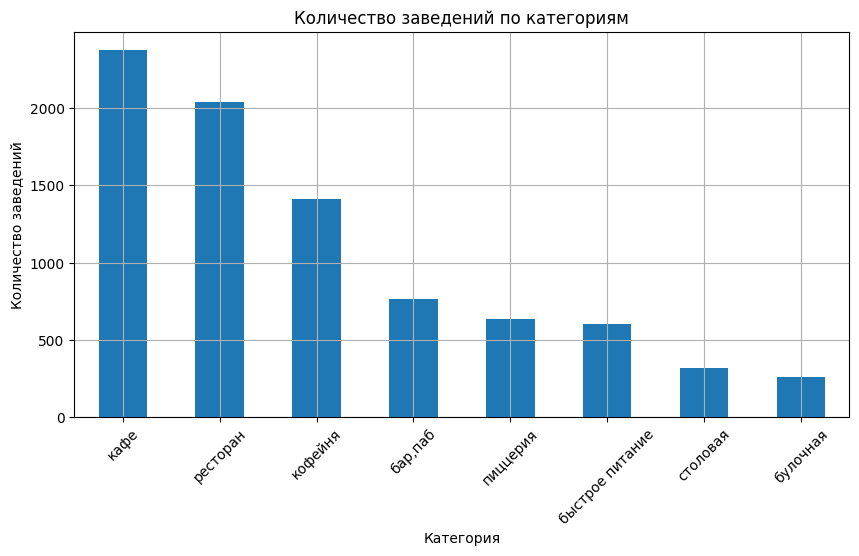

In [38]:
df_clean['category'].value_counts().plot(
    kind='bar',
    figsize=(10, 5),
    title='Количество заведений по категориям',
    rot = 45,
    grid=True
)
plt.xlabel('Категория')
plt.ylabel('Количество заведений')
plt.show()

В данных выделено 8 категорий заведений.

Лидеры по количеству объектов: `кафе` (2376), `ресторан` (2042), `кофейня` (1413). Эти категории формируют основную часть рынка.

---

### Распределение заведений по округам

Сравнение количества заведений по округам Москвы и структуры категорий в ЦАО.

In [39]:
print('Распределение данных по значениям столбца district:')
df_clean['district'].value_counts().to_frame('Категория').style.bar(color="#4E4EF758")

Распределение данных по значениям столбца district:


,Категория
district,
Центральный административный округ,2242
Северный административный округ,898
Южный административный округ,892
Северо-Восточный административный округ,890
Западный административный округ,850
Восточный административный округ,798
Юго-Восточный административный округ,714
Юго-Западный административный округ,709
Северо-Западный административный округ,409


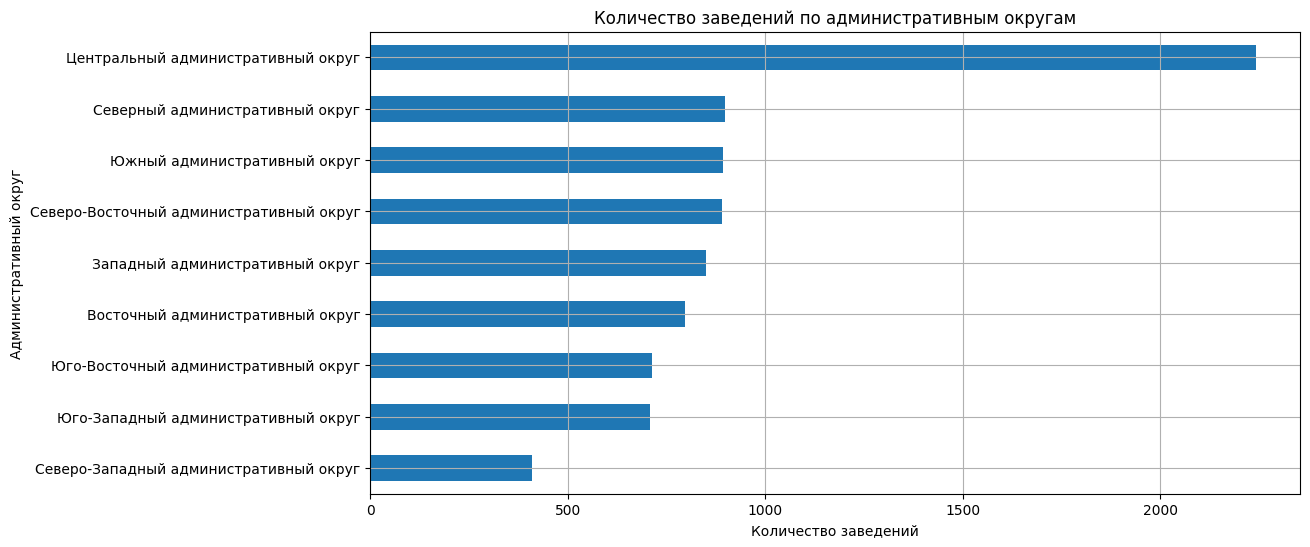

In [40]:
df_clean['district'].value_counts().sort_values(ascending=True).plot(
    kind='barh',
    figsize=(12, 6),
    title='Количество заведений по административным округам',
    grid=True
)
plt.xlabel('Количество заведений')
plt.ylabel('Административный округ')
plt.show()

По числу заведений лидирует Центральный административный округ (2242 объекта). Минимальное количество — в Северо-Западном административном округе (409).

In [41]:
print('''Распределение данных по значениям столбца category
для центрального административного округа:''')
df_clean.query('district == "Центральный административный округ"')['category'].value_counts().to_frame('Категория').style.bar(color="#4E4EF758")

Распределение данных по значениям столбца category
для центрального административного округа:


,Категория
category,
ресторан,670
кафе,464
кофейня,428
"бар,паб",364
пиццерия,113
быстрое питание,87
столовая,66
булочная,50


In [42]:
print('''Распределение данных по значениям столбца category
для центрального административного округа в '%' :''')
df_clean.query('district == "Центральный административный округ"')['category'].value_counts(normalize=True).mul(100).round(2).to_frame('Доля категорий, %').style.bar(color="#4E4EF758")

Распределение данных по значениям столбца category
для центрального административного округа в '%' :


,"Доля категорий, %"
category,
ресторан,29.880000
кафе,20.700000
кофейня,19.090000
"бар,паб",16.240000
пиццерия,5.040000
быстрое питание,3.880000
столовая,2.940000
булочная,2.230000


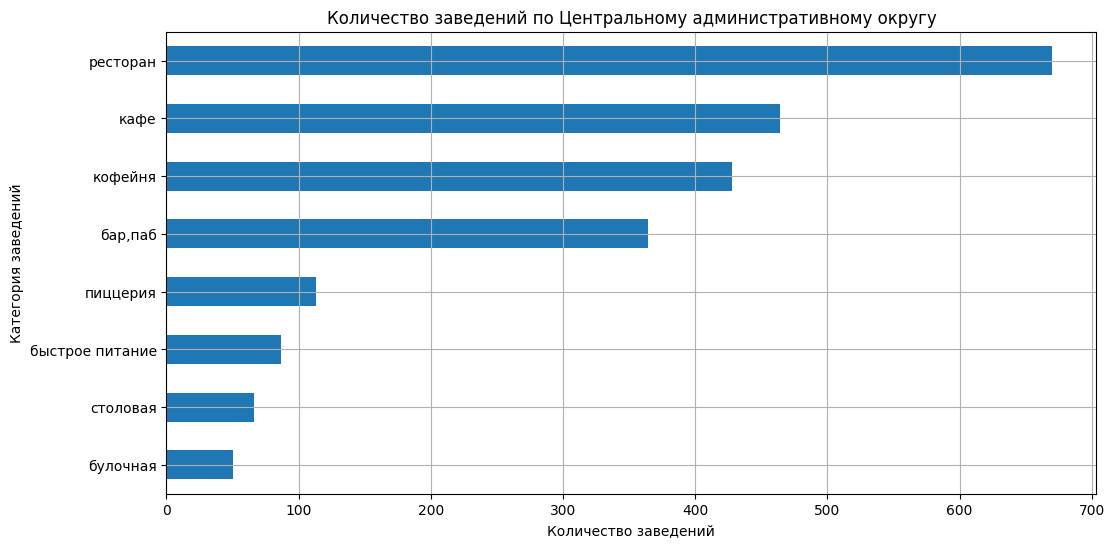

In [43]:
df_clean.query('district == "Центральный административный округ"')['category'].value_counts().sort_values(ascending=True).plot(
    kind='barh',
    figsize=(12, 6),
    title='Количество заведений по Центральному административному округу',
    grid=True
)
plt.xlabel('Количество заведений')
plt.ylabel('Категория заведений')
plt.show()

В ЦАО преобладают четыре категории:
- рестораны — 29.88%,
- кафе — 20.70%,
- кофейни — 19.09%,
- бары/пабы — 16.24%.

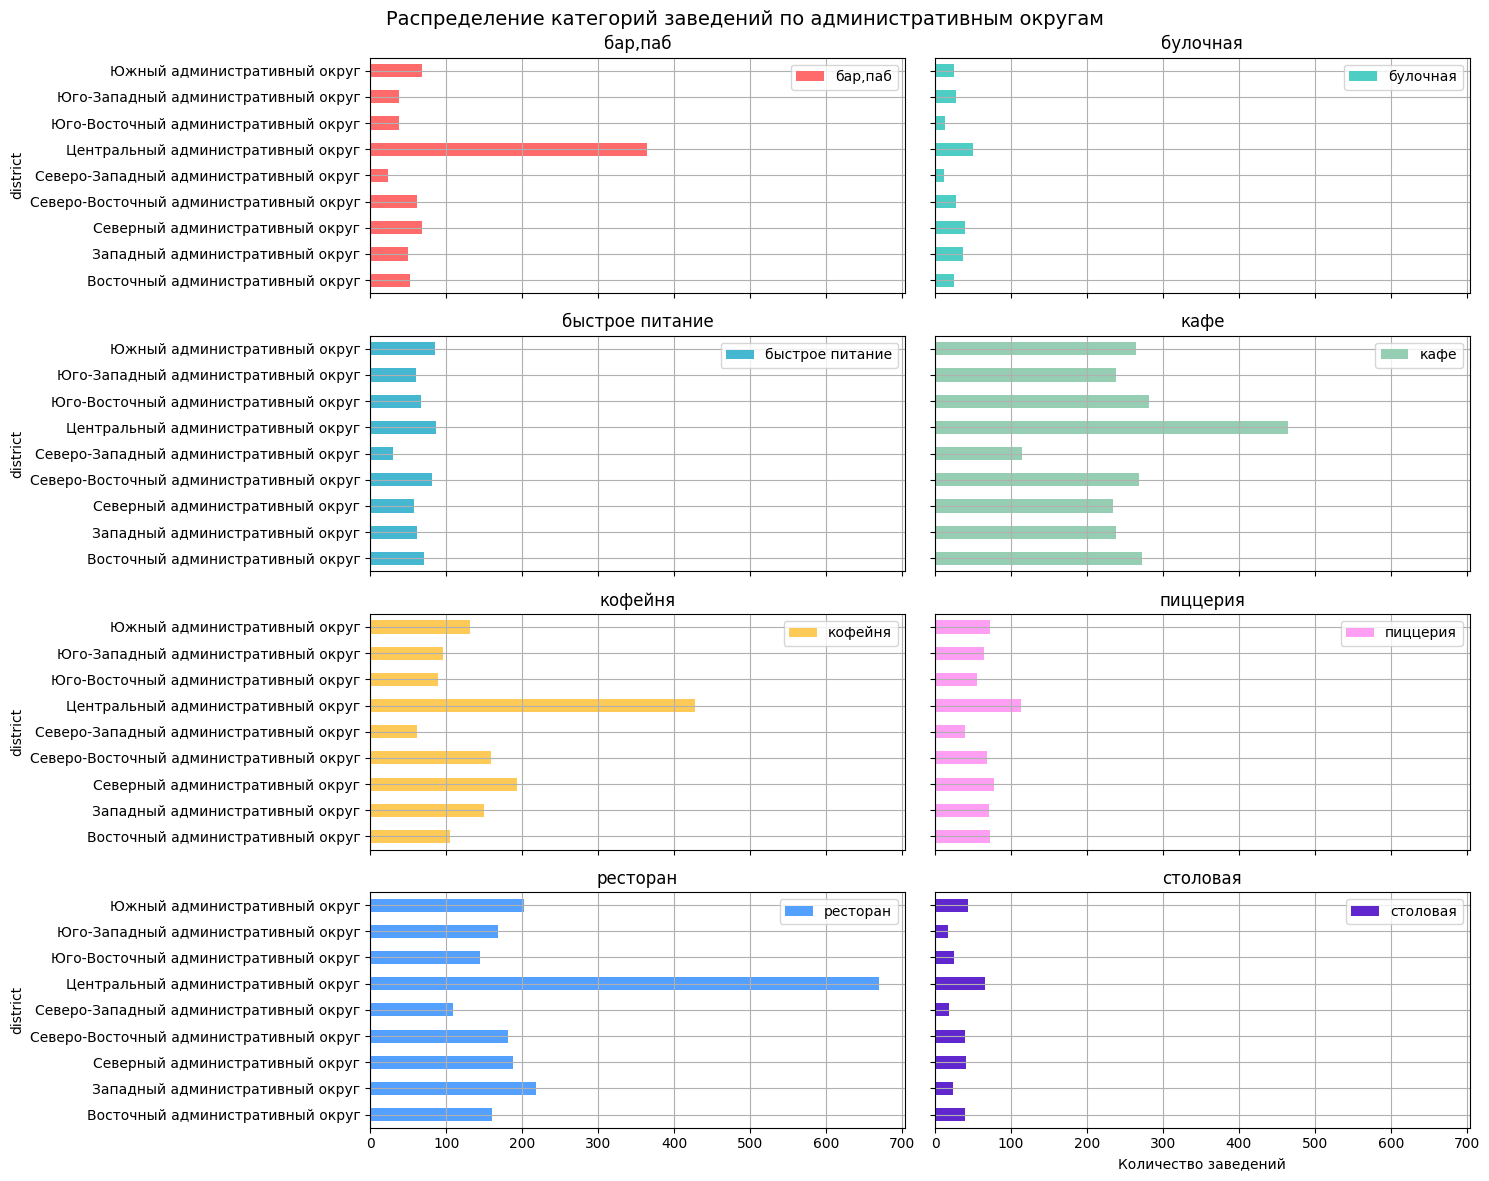

In [44]:
df_clean.groupby('district')['category'].value_counts().unstack(fill_value=0).plot(
    kind='barh',
    figsize=(15, 12),
    subplots=True,
    layout=(4, 2),
    title='Распределение категорий по округам',
    rot=0,
    grid=True,
    sharey=True,
    color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3', '#54A0FF', '#5F27CD']
)

plt.suptitle('Распределение категорий заведений по административным округам', fontsize=14)
plt.xlabel('Количество заведений')
plt.ylabel('Округ')
plt.tight_layout()
plt.show()

Явных аномалий в распределении категорий по округам не выявлено; картина согласуется с предыдущими визуализациями.

Промежуточные итоги по округам:
- максимальная концентрация заведений — в ЦАО;
- минимальная — в Северо-Западном округе;
- в центре доминируют рестораны, кафе, кофейни и бары/пабы;
- в остальных округах структура категорий более сбалансирована.

---

### Сетевые и несетевые заведения

Сравнение долей сетевых и несетевых форматов в целом и в разрезе категорий.

In [45]:
print('''Заведение не сетевое = 0
Заведение сетевое = 1''')
df_clean['chain'].value_counts().to_frame('Кол-во заведений').style.background_gradient(cmap='Accent')

Заведение не сетевое = 0
Заведение сетевое = 1


,Кол-во заведений
chain,
0,5199
1,3203


In [46]:
print('''Заведение не сетевое = 0
Заведение сетевое = 1''')
df_clean['chain'].value_counts(normalize=True).mul(100).round(2).to_frame('Доля заведений, %').style.background_gradient(cmap='Accent')

Заведение не сетевое = 0
Заведение сетевое = 1


,"Доля заведений, %"
chain,
0,61.880000
1,38.120000


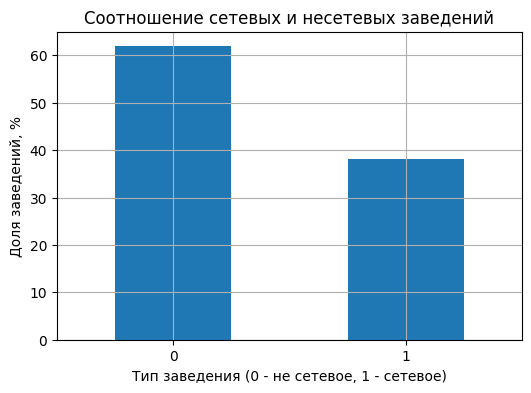

In [47]:
(df_clean['chain'].value_counts(normalize=True).sort_index() * 100).plot(
    kind='bar',
    grid=True,
    figsize=(6,4),
    rot=0,
    title='Соотношение сетевых и несетевых заведений'
)

plt.xlabel('Тип заведения (0 - не сетевое, 1 - сетевое)')
plt.ylabel('Доля заведений, %')
plt.show()


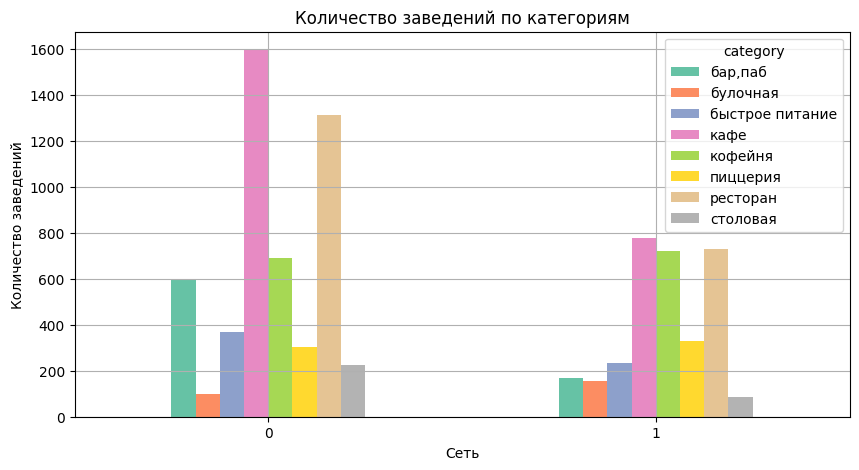

In [48]:
df_clean.groupby(['chain', 'category']).size().unstack().plot(
    kind='bar',
    figsize=(10, 5),
    title='Количество заведений по категориям',
     rot = 0,
    grid=True,
    colormap='Set2')
plt.xlabel('Сеть')
plt.ylabel('Количество заведений')
plt.show()

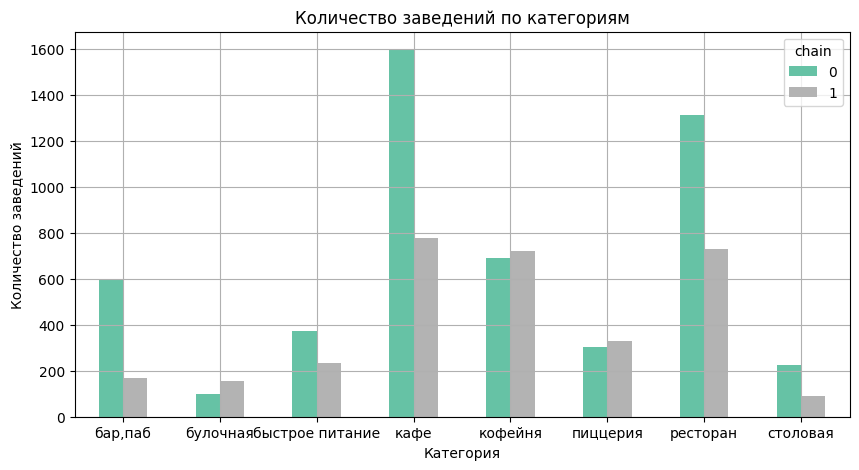

In [49]:
df_clean.groupby(['category', 'chain']).size().unstack().plot(
    kind='bar',
    figsize=(10, 5),
    title='Количество заведений по категориям',
     rot = 0,
    grid=True,
    colormap='Set2')
plt.xlabel('Категория')
plt.ylabel('Количество заведений')
plt.show()

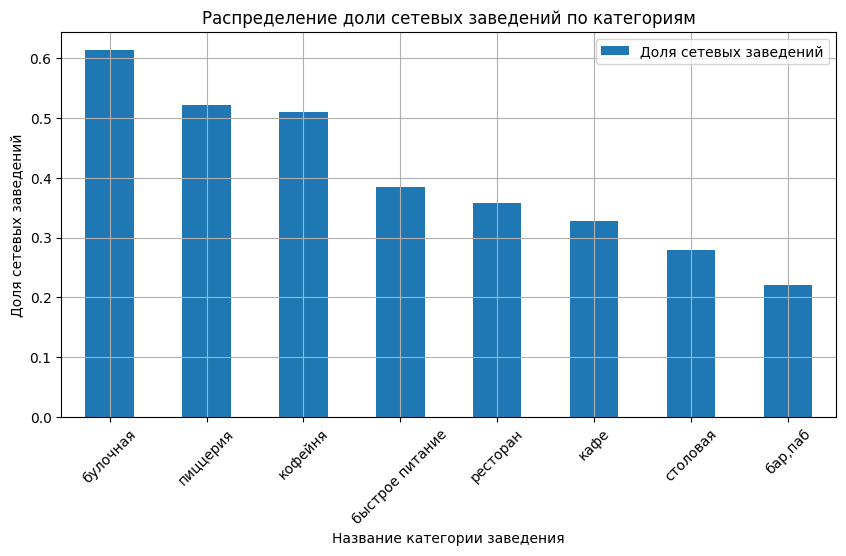

In [50]:
df_clean.groupby('category')['chain'].mean().sort_values(ascending=False).to_frame('Доля сетевых заведений').plot(
    kind='bar',
    grid=True,
    figsize=(10,5),
    rot=45,
    title='Распределение доли сетевых заведений по категориям')

plt.ylabel('Доля сетевых заведений')
plt.xlabel('Название категории заведения')
plt.show()

Большая часть заведений Москвы работает в несетевом формате (61.88%), доля сетевых — 38.12%.

Сетевой формат чаще встречается у булочных, пиццерий и кофеен, где проще масштабировать бизнес за счёт стандартизации процессов.

---

### Посадочные места

Анализ распределения количества посадочных мест, выбросов и типичных значений по категориям.

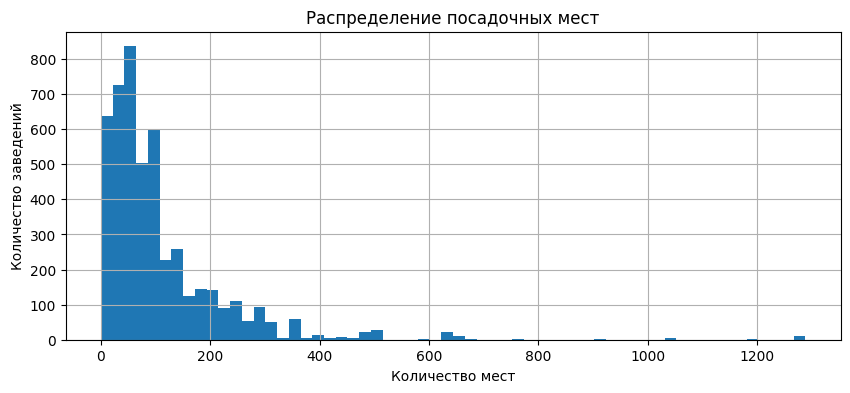

In [51]:
df_clean['seats'].dropna().plot(
    kind='hist',
    bins=60,
    figsize=(10,4),
    grid=True,
    title='Распределение посадочных мест')
plt.xlabel('Количество мест')
plt.ylabel('Количество заведений')
plt.show()

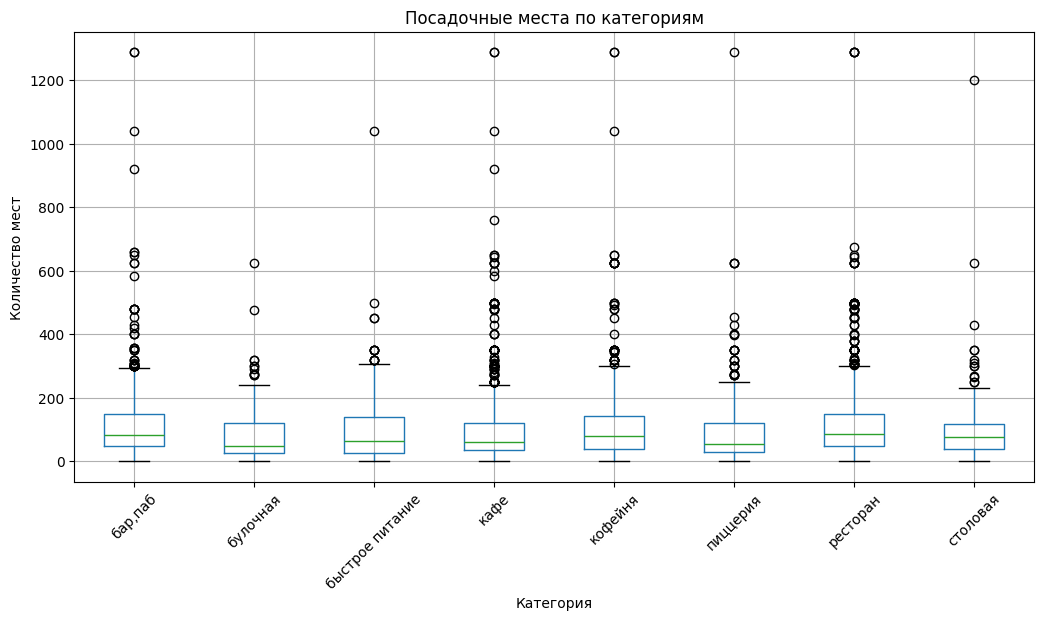

In [52]:
df_clean[['category','seats']].dropna().boxplot(
    by='category',
    figsize=(12,6),
    grid=True,
    rot=45)
plt.title('Посадочные места по категориям')
plt.suptitle('')
plt.xlabel('Категория')
plt.ylabel('Количество мест')
plt.show()


In [53]:
df_clean.groupby('category')['seats'].median().sort_values(ascending=False).to_frame('Медиана кол-ва посадочных мест').style.bar(color="#4E4EF758")

,Медиана кол-ва посадочных мест
category,
ресторан,86.000000
"бар,паб",82.000000
кофейня,80.000000
столовая,75.500000
быстрое питание,65.000000
кафе,60.000000
пиццерия,55.000000
булочная,50.000000


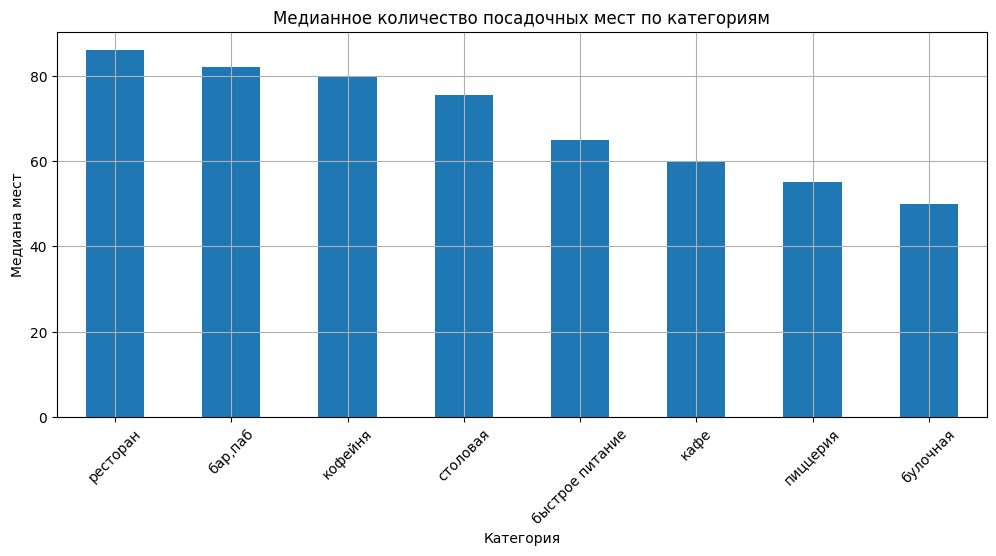

In [54]:
df_clean.groupby('category')['seats'].median().sort_values(ascending=False).plot(
    kind='bar',
    figsize=(12,5),
    grid=True,
    rot = 45,
    title='Медианное количество посадочных мест по категориям')
plt.xlabel('Категория')
plt.ylabel('Медиана мест')
plt.show()

Распределение `seats` имеет широкий разброс и выбросы (включая значения выше 1000), поэтому для «типичного» значения использована медиана.

Медиана посадочных мест по категориям:
1. ресторан — 86
2. бар,паб — 82
3. кофейня — 80
4. столовая — 75.5
5. быстрое питание — 65
6. кафе — 60
7. пиццерия — 55
8. булочная — 50

---

### Рейтинг заведений

Анализ распределения рейтингов и сравнение средних оценок по категориям.

Общая средняя оценка:  4.2300167
Общая медианная оценка:  4.3


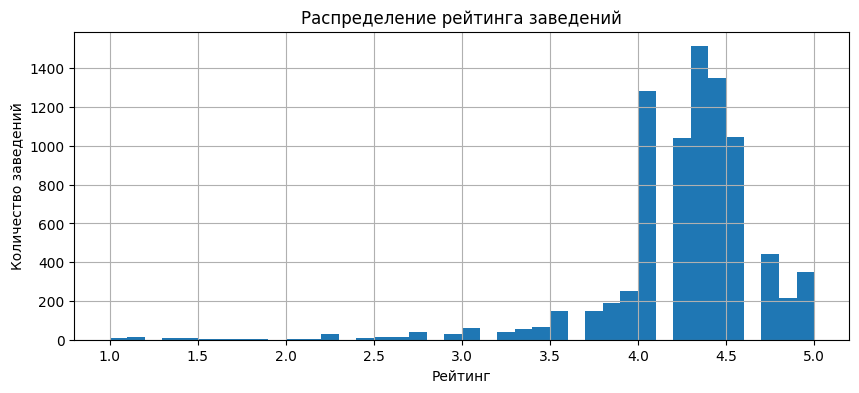

In [55]:
print('Общая средняя оценка: ', df_clean['rating'].mean())
print('Общая медианная оценка: ', df_clean['rating'].median())
df_clean['rating'].dropna().plot(
    kind='hist',
    bins=40,
    figsize=(10,4),
    grid=True,
    title='Распределение рейтинга заведений')
plt.xlabel('Рейтинг')
plt.ylabel('Количество заведений')
plt.show()

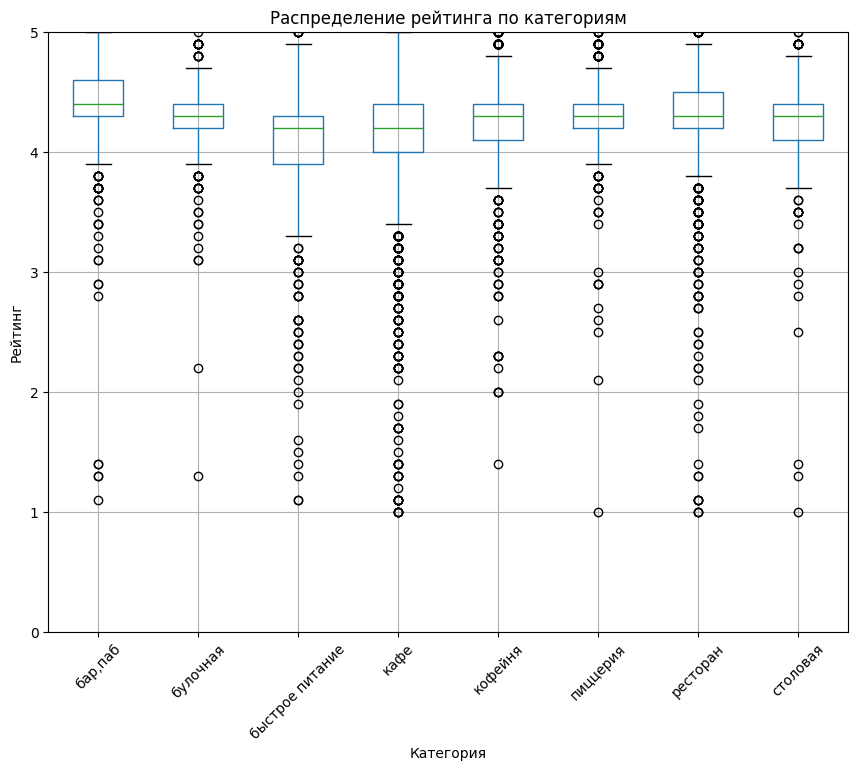

In [56]:
df_clean.boxplot(
    column='rating',
    by='category',
    figsize=(10, 8),
    grid=True,
    rot=45)
plt.title('Распределение рейтинга по категориям')
plt.suptitle('')
plt.xlabel('Категория')
plt.ylabel('Рейтинг')
plt.ylim(0, 5)
plt.show()

In [57]:
df_clean.groupby('category')['rating'].agg(['mean', 'median', 'std', 'count']).round(2).sort_values('mean', ascending=False).style.background_gradient(cmap='Blues')

,mean,median,std,count
category,,,,
"бар,паб",4.390000,4.400000,0.380000,764
пиццерия,4.300000,4.300000,0.340000,633
ресторан,4.290000,4.300000,0.410000,2042
кофейня,4.280000,4.300000,0.370000,1413
булочная,4.270000,4.300000,0.390000,256
столовая,4.210000,4.300000,0.450000,315
кафе,4.120000,4.200000,0.570000,2376
быстрое питание,4.050000,4.200000,0.560000,603


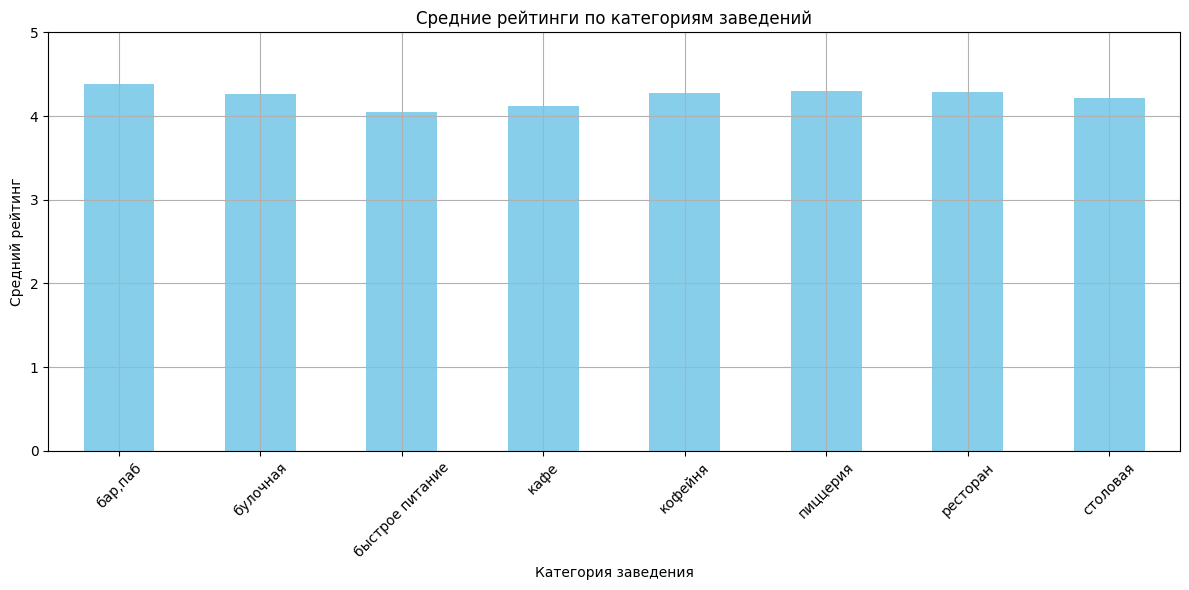

In [58]:
df_clean.groupby('category')['rating'].mean().plot(
    kind='bar',
    figsize=(12, 6),
    color='skyblue',
    grid=True,
    rot=45,
    ylim=(0,5),
    title='Средние рейтинги по категориям заведений')

plt.xlabel('Категория заведения')
plt.ylabel('Средний рейтинг')
plt.tight_layout()
plt.show()

Рейтинг заведений в выборке высокий: среднее значение — 4.23 из 5.

По среднему рейтингу лидируют бары/пабы (4.39), минимальное значение у категории «быстрое питание» (4.05).

Распределение рейтингов скошено в сторону высоких значений, что может отражать эффект самоотбора пользовательских отзывов.

---

### Корреляция рейтинга с признаками

Оценка связи рейтинга с числовыми и категориальными параметрами и проверка наиболее выраженной зависимости.

In [59]:
df_corr = df_clean.copy()
df_corr['price'] = df_corr['price'].replace('неопределено', np.nan)
df_corr[['rating', 'seats', 'chain', 'is_24_7', 'category', 'district', 'price']].phik_matrix(interval_cols=['rating','seats']).style.background_gradient(cmap='Blues')

,rating,seats,chain,is_24_7,category,district,price
rating,1.000000,0.000000,0.118857,0.158885,0.198739,0.189453,0.262056
seats,0.000000,1.000000,0.056523,0.038072,0.048923,0.352440,0.088146
chain,0.118857,0.056523,1.000000,0.050736,0.266000,0.064473,0.218211
is_24_7,0.158885,0.038072,0.050736,1.000000,0.230250,0.065881,0.066287
category,0.198739,0.048923,0.266000,0.230250,1.000000,0.174584,0.566933
district,0.189453,0.352440,0.064473,0.065881,0.174584,1.000000,0.202787
price,0.262056,0.088146,0.218211,0.066287,0.566933,0.202787,1.000000


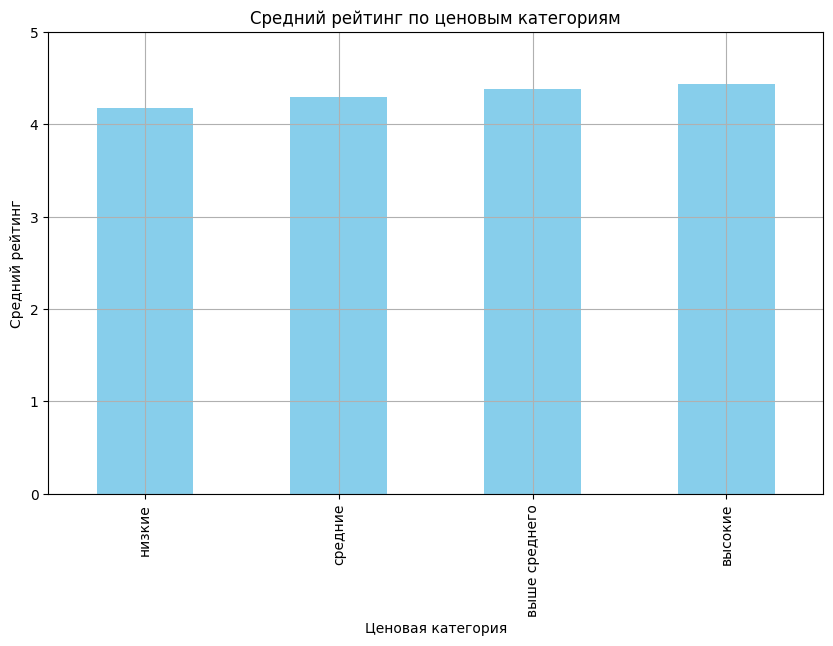

In [60]:
price_order = ['низкие', 'средние', 'выше среднего', 'высокие']

(df_corr.groupby('price')['rating']
 .mean()
 .reindex(price_order)
 .plot(
    kind='bar',
    grid=True,
    figsize=(10,6),
    title='Средний рейтинг по ценовым категориям',
    color='skyblue'
 ))

plt.xlabel('Ценовая категория')
plt.ylabel('Средний рейтинг')
plt.ylim(0,5)
plt.show()


In [61]:
df_corr.groupby('price')['rating'].mean().sort_values(ascending=False).to_frame('Средний рейтинг').style.background_gradient(cmap='winter')

,Средний рейтинг
price,
высокие,4.436611
выше среднего,4.386347
средние,4.297874
низкие,4.173077


Наиболее выраженная связь рейтинга наблюдается с ценовой категорией `price`: в более дорогих сегментах средний рейтинг выше.

Эффект устойчивый, но умеренный: различия между группами есть, однако разброс внутри категорий сохраняется.

---

### Топ-15 сетей Москвы и их рейтинги

Анализ популярных сетей по числу точек, среднему рейтингу и распределению по категориям заведений.

In [62]:
df_clean[df_clean['chain'] == 1]['name'].value_counts().head(15).to_frame('Кол-во заведений в сети').style.background_gradient(cmap='Accent')

,Кол-во заведений в сети
name,
шоколадница,120
домино'с пицца,76
додо пицца,74
one price coffee,71
яндекс лавка,69
cofix,65
prime,50
хинкальная,44
кофепорт,42


In [63]:
df_clean[df_clean['name'].isin(df_clean[df_clean['chain'] == 1]['name'].value_counts().head(15).index)].groupby('name')['rating'].mean().sort_values(ascending=False).to_frame().style.background_gradient(cmap='winter')

,rating
name,
буханка,4.396875
кулинарная лавка братьев караваевых,4.394872
хинкальная,4.322727
додо пицца,4.286487
му-му,4.229630
шоколадница,4.177500
домино'с пицца,4.171428
кофепорт,4.147619
теремок,4.123684


In [64]:
tmp = df_clean.copy()          # создаем копию текущего датасета
name_tmp = 'му-му'       # задаем имя столбца для проверки уникальных категорий
print(f'Заведения с одинаковым именем {name_tmp} относятся к разным категориям:\n\
{", ".join(tmp[tmp.name == name_tmp].category.unique())}')

Заведения с одинаковым именем му-му относятся к разным категориям:
кафе, ресторан, кофейня, быстрое питание, пиццерия, столовая, бар,паб


In [65]:
top15 = df_clean.query('chain == 1').groupby(['name', 'category']).agg(count_object=('id', 'size'),mean_rating=('rating', 'mean')).sort_values('count_object', ascending=False).head(15)
display(top15.style.format({'mean_rating': '{:.3f}'}).background_gradient(cmap='Blues', subset=['count_object','mean_rating']))

,,count_object,mean_rating
name,category,,
шоколадница,кофейня,119,4.178
домино'с пицца,пиццерия,76,4.170
додо пицца,пиццерия,74,4.286
one price coffee,кофейня,71,4.065
яндекс лавка,ресторан,69,3.872
cofix,кофейня,65,4.075
prime,ресторан,49,4.114
кофепорт,кофейня,42,4.148
кулинарная лавка братьев караваевых,кафе,39,4.395


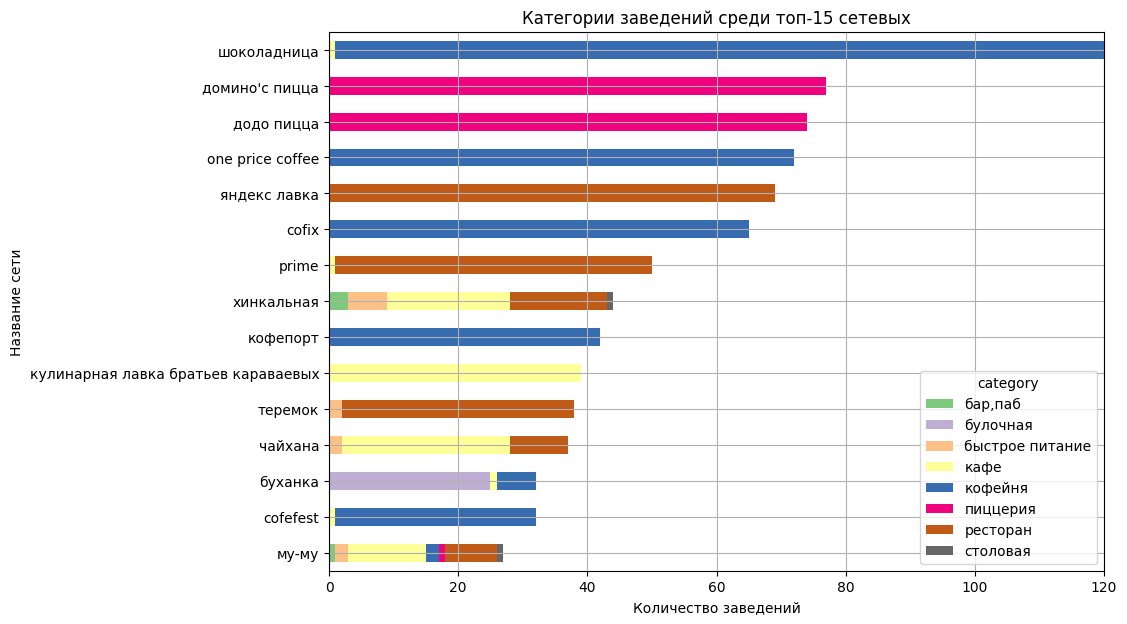

In [66]:
top_names = (df_clean.query('chain == 1')['name'].value_counts().head(15).index)

cat_dist = (df_clean[df_clean['name'].isin(top_names)].groupby(['name','category']).size().unstack(fill_value=0))

cat_dist = cat_dist.loc[cat_dist.sum(axis=1).sort_values(ascending=True).index]

cat_dist.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 7),
    grid=True,
    colormap='Accent',
    title='Категории заведений среди топ-15 сетевых'
)

plt.xlabel('Количество заведений')
plt.ylabel('Название сети')
plt.show()

In [67]:
df_clean[df_clean['name'].isin(df_clean.query('chain == 1')['name'].value_counts().head(15).index)].groupby('category').size().sort_values(ascending=False).to_frame('Количество заведений').style.bar(color="#4E4EF758")

,Количество заведений
category,
кофейня,337
ресторан,186
пиццерия,152
кафе,100
булочная,25
быстрое питание,12
"бар,паб",4
столовая,2


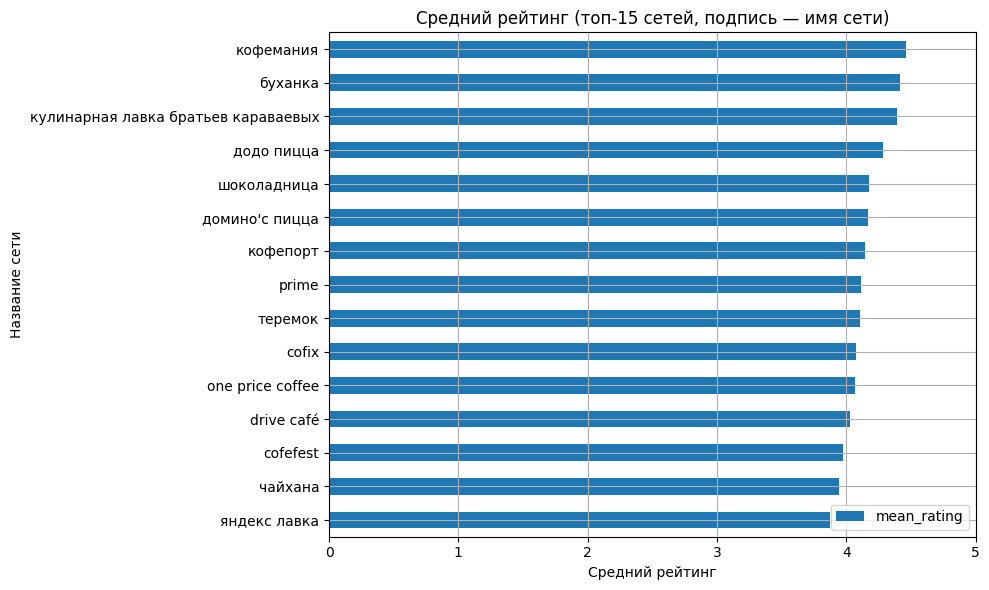

In [68]:
top15.reset_index().sort_values('mean_rating').plot(
    kind='barh',
    x='name',
    y='mean_rating',
    figsize=(10, 6),
    grid=True,
    title='Средний рейтинг (топ-15 сетей, подпись — имя сети)')
plt.xlabel('Средний рейтинг')
plt.ylabel('Название сети')
plt.xlim(0, 5)
plt.tight_layout()
plt.show()

В топ-15 по числу точек входят крупные сети, преимущественно из сегментов кофеен, ресторанов и пиццерий.

Средние рейтинги топ-15 в целом высокие и близки между собой.
- максимум: «буханка» (~4.40);
- минимум: «яндекс лавка» (~3.87).

---

### Средний чек по округам Москвы

Сравнение распределений среднего чека по округам и оценка влияния удалённости от центра.

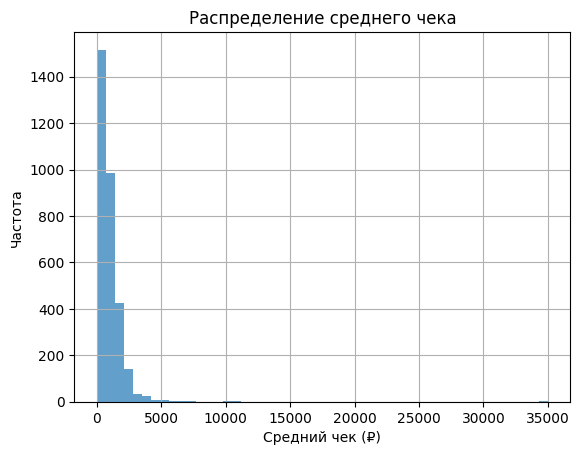

In [69]:
df_clean['middle_avg_bill'].plot(
    kind='hist',
    bins=50,
    grid=True,
    title='Распределение среднего чека',
    alpha=0.7
)
plt.xlabel('Средний чек (₽)')
plt.ylabel('Частота')
plt.show()

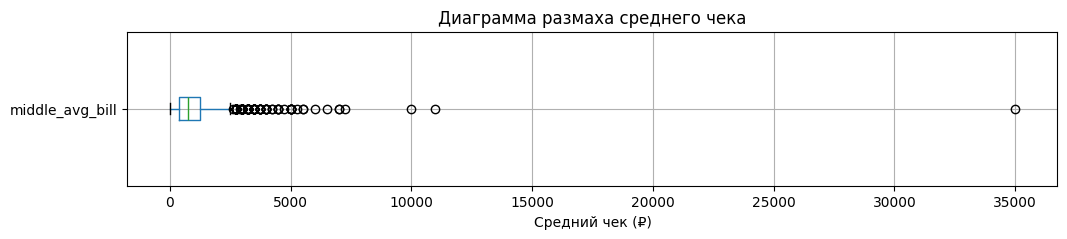

In [70]:
df_clean[['middle_avg_bill']].boxplot(
    figsize=(12, 2),
    grid=True,
    vert=False
)
plt.title('Диаграмма размаха среднего чека')
plt.xlabel('Средний чек (₽)')
plt.show()

In [71]:
stats_by_dist = df_clean.groupby('district')['middle_avg_bill'].agg(['count','median','mean']).sort_values('mean', ascending=False)
stats_by_dist.style.bar(subset=['median', 'mean'], color="#4E4EF758")

,count,median,mean
district,,,
Центральный административный округ,1060,1000.000000,1191.057547
Западный административный округ,306,1000.000000,1053.225490
Северный административный округ,322,650.000000,927.959627
Южный административный округ,314,500.000000,834.398089
Северо-Западный административный округ,157,700.000000,822.222930
Восточный административный округ,260,575.000000,820.626923
Юго-Западный административный округ,235,600.000000,792.561702
Северо-Восточный административный округ,301,500.000000,716.611296
Юго-Восточный административный округ,194,450.000000,654.097938


In [72]:
((stats_by_dist['median'] - stats_by_dist.loc['Центральный административный округ','median'])/ stats_by_dist.loc['Центральный административный округ','median'] * 100).to_frame('Отклонение от ЦАО, %').style.bar(color='#4E4EF758')

,"Отклонение от ЦАО, %"
district,
Центральный административный округ,0.000000
Западный административный округ,0.000000
Северный административный округ,-35.000000
Южный административный округ,-50.000000
Северо-Западный административный округ,-30.000000
Восточный административный округ,-42.500000
Юго-Западный административный округ,-40.000000
Северо-Восточный административный округ,-50.000000
Юго-Восточный административный округ,-55.000000


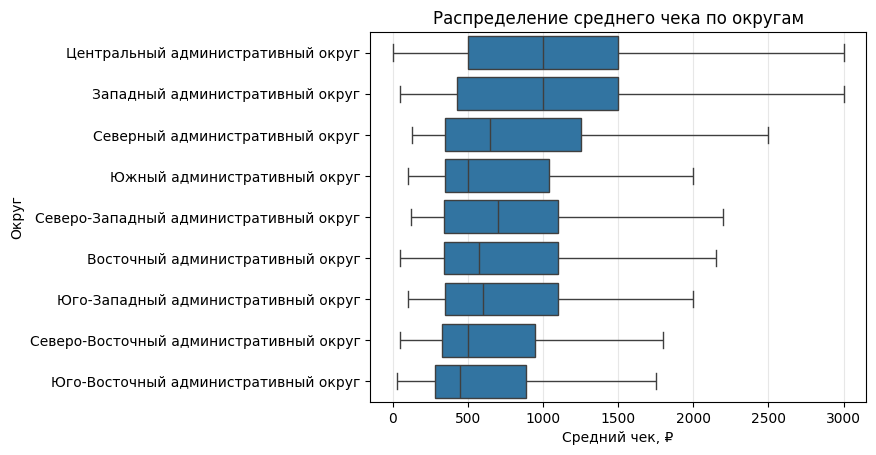

In [73]:

order = (df_clean.query('middle_avg_bill.notna()').groupby('district')['middle_avg_bill'].mean().sort_values(ascending=False).index)

sns.boxplot(data=df_clean.query('middle_avg_bill.notna()'),
    y='district',
    x='middle_avg_bill',
    order=order,
    showfliers=False)

plt.title('Распределение среднего чека по округам')
plt.xlabel('Средний чек, ₽')
plt.ylabel('Округ')
plt.grid(True, axis='x', alpha=0.3)
plt.show()

Средний чек заметно различается по округам Москвы.

ЦАО лидирует по среднему уровню цен; второе место занимает Западный административный округ. Вне ЦАО медианный чек ниже на ~30–55% относительно ЦАО.

---


---

### Промежуточный вывод

Ключевые инсайты этапа EDA по структуре рынка, сетевому формату, рейтингам и среднему чеку.

Ключевые результаты EDA:
- рынок сосредоточен в категориях `кафе`, `ресторан`, `кофейня`;
- по числу объектов лидирует ЦАО, минимум — в Северо-Западном округе;
- доля сетевых заведений составляет 38.12%, чаще это булочные, пиццерии и кофейни;
- доля заведений 24/7 — 9.19% (772 объекта);
- медиана `seats` зависит от категории: от 50 (булочные) до 86 (рестораны);
- средний рейтинг высокий (4.23), максимум у баров/пабов, минимум у быстрого питания;
- вне ЦАО медианный чек ниже на ~30–55% относительно ЦАО.

## 4. Итоговый вывод и рекомендации

Сводный вывод по исследованию и практические рекомендации для открытия заведения.

Итоговый вывод и рекомендации

**Общий обзор работы**
- Выполнен полный цикл EDA по заведениям общественного питания Москвы.
- Данные объединены, очищены, приведены к рабочим типам и дополнены аналитическим признаком `is_24_7`.
- По ключевым бизнес-вопросам построены срезы и визуализации.

**Главные выводы**
- Основной объём рынка формируют три категории: кафе, рестораны и кофейни.
- ЦАО лидирует одновременно по числу объектов и уровню цен.
- Сетевые заведения занимают 38.12%; чаще это булочные, пиццерии и кофейни.
- Доля заведений 24/7 составляет 9.19%: формат заметный, но не доминирующий.
- По `seats` наблюдается сильный разброс, поэтому для типичного значения корректнее использовать медиану.
- Средний рейтинг по рынку — 4.23; выше всего у баров/пабов, ниже всего у быстрого питания.
- Более дорогие ценовые категории связаны с более высоким средним рейтингом.

**Рекомендации**
- Если цель — масштабируемая сеть, приоритетны категории с уже доказанной сетевой моделью: кофейни, пиццерии, булочные.
- Если цель — одна точка, целесообразно делать локальную концепцию с опорой на локацию и чёткое позиционирование по цене/сервису.
- Для локаций в ЦАО закладывать более высокий ценовой сегмент и конкуренцию за качество сервиса.
- Формат 24/7 использовать точечно: доля таких заведений невысока, поэтому режим должен подтверждаться операционной и спросовой моделью.

**Ограничения исследования**
- Более 60% значений в `price` отсутствуют, поэтому выводы по цене интерпретируются с осторожностью.
- Рейтинги пользовательские и могут содержать поведенческий шум (субъективность оценок).
- В `seats` есть пропуски и пограничные значения, что влияет на точность оценок по посадке.